In [ ]:
!pip install transformers
!pip install torchvision
!pip install datasets
!pip install nlpaug
!pip install ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# TEXT AUGMENTATION
import nlpaug.augmenter.word as naw
import random

text_aug = naw.SynonymAug(aug_src='wordnet')

def augment_text(text, n=2):
    return [text_aug.augment(text) for _ in range(n)]

# IMAGE AUGMENTATION
from torchvision import transforms
from PIL import Image

image_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def augment_image(pil_image, n=2):
    return [image_aug(pil_image) for _ in range(n)]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#mount to read/write other files in folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parthplc/facebook-hateful-meme-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/facebook-hateful-meme-dataset


In [ ]:
import torch
import clip
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from sklearn.metrics import accuracy_score
import os
import numpy as np

In [ ]:
df = pd.read_json(path+'/data/train.jsonl', lines=True)
df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


Text: its their character not their color that matters
Label: Not Hateful


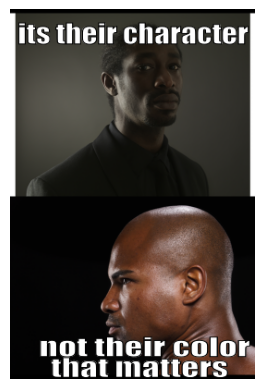

In [ ]:
sample = df.iloc[0]
image_path = path + f"/data/{sample['img']}"
text = sample['text']
label = sample['label']

print(f"Text: {text}")
print(f"Label: {'Hateful' if label == 1 else 'Not Hateful'}")
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 122MiB/s]


In [ ]:
class HatefulMemesDataset(Dataset):
    def __init__(self, dataframe, root_dir, preprocess, clip_tokenizer):
        self.text_augment = text_aug
        self.image_augment = image_aug
        self.apply_augmentation = True  # flip to False during evaluation
        self.df = dataframe
        self.root_dir = root_dir
        self.preprocess = preprocess
        self.tokenizer = clip_tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = os.path.join(self.root_dir, row['img'])
        image = Image.open(image_path).convert("RGB")
        text = row['text']
        label = row['label']

        if self.apply_augmentation:
            if random.random() < 0.5:
                text = self.text_augment.augment(text)
            if random.random() < 0.5:
                image = self.image_augment(image)
            else:
                image = self.preprocess(image)
        else:
            image = self.preprocess(image)

        text = clip.tokenize(text, truncate=True)[0]
        return image, text, label


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('punkt')

dataset = HatefulMemesDataset(df, path + '/data', preprocess, clip.tokenize)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

labels = [dataset[i][2] for i in train_dataset.indices]
pos_count = sum(labels)
neg_count = len(labels) - pos_count
#higher weight for minority class
pos_weight = torch.tensor([neg_count / pos_count])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip_model = clip_model
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(clip_model.visual.output_dim + clip_model.text_projection.shape[1], 1)

    def forward(self, image, text):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)

        combined = torch.cat([image_features, text_features], dim=1)
        output = self.fc(combined)
        return output


In [ ]:
model = CLIPClassifier(clip_model).to(device).float()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    for images, texts, labels in dataloader:
        images = images.to(device).float()
        texts = texts.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(images, texts).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

for epoch in range(15):
    loss = train_epoch(model, train_loader)
    print(f"Epoch {epoch+1} - Loss: {loss:.4f}")
    scheduler.step()


Epoch 1 - Loss: 0.6524
Epoch 2 - Loss: 0.6257
Epoch 3 - Loss: 0.6105
Epoch 4 - Loss: 0.6012
Epoch 5 - Loss: 0.5939
Epoch 6 - Loss: 0.5901
Epoch 7 - Loss: 0.5848
Epoch 8 - Loss: 0.5821
Epoch 9 - Loss: 0.5775
Epoch 10 - Loss: 0.5745
Epoch 11 - Loss: 0.5725
Epoch 12 - Loss: 0.5729
Epoch 13 - Loss: 0.5698
Epoch 14 - Loss: 0.5695
Epoch 15 - Loss: 0.5675


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], [] #Rutvij added for all probs - saving output

    with torch.no_grad():
        for images, texts, labels in dataloader:
            images, texts = images.to(device), texts.to(device)
            outputs = model(images, texts).squeeze()
            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

            #Rutvij added 2 lines
            batch_probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.extend(batch_probs)

    acc = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {acc:.4f}")

    return all_labels, all_probs, all_preds

all_labels, all_probs, all_preds = evaluate(model, val_loader)


Validation Accuracy: 0.7006


In [ ]:
#Validation Accuracy: 0.6776

## Save Outputs

In [ ]:
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# save
np.save(os.path.join(output_dir, "y_true_clip.npy"), np.array(all_labels))
np.save(os.path.join(output_dir, "y_probs_clip.npy"), np.array(all_probs))

#click the folder icon on the left navigation panel. Open up "outputs". Download the contents locally
#and store them in the google drive "outputs" folder.